# Visualize terminal state and latent time

In [14]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import scipy

import cellrank as cr

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from rgv_tools import DATA_DIR, FIG_DIR

## Define functions

In [2]:
def min_max_scaling(data):
    # Compute min and max values for each feature
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    # Perform min-max scaling
    scaled_data = (data - min_vals) / (max_vals - min_vals)
    
    return scaled_data

## Constants

In [3]:
DATASET = "zebrafish"
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

## Data loading

In [15]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")

## Using CellRank predict terminal states

In [16]:
## compute cellrank graph
n_states = 8
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
g = cr.estimators.GPCCA(0.8*vk+0.2*ck)

## evaluate the fate prob on original space
g.compute_macrostates(n_states=n_states, n_cells = 30,cluster_key="cell_type")

100%|██████████| 697/697 [00:00<00:00, 1635.91cell/s]


GPCCA[kernel=(0.8 * VelocityKernel[n=697] + 0.2 * ConnectivityKernel[n=697]), initial_states=None, terminal_states=None]

In [17]:
terminal_states = [
        "mNC_head_mesenchymal",
        "mNC_arch2",
        "mNC_hox34",
        "Pigment",
    ]

g.set_terminal_states(terminal_states)

GPCCA[kernel=(0.8 * VelocityKernel[n=697] + 0.2 * ConnectivityKernel[n=697]), initial_states=None, terminal_states=['Pigment', 'mNC_arch2', 'mNC_head_mesenchymal', 'mNC_hox34']]

/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/icb/weixu.wang/miniconda3/envs/regvelo_test/lib/python3.10/site-packages/scvelo/plotting/utils.py:1392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


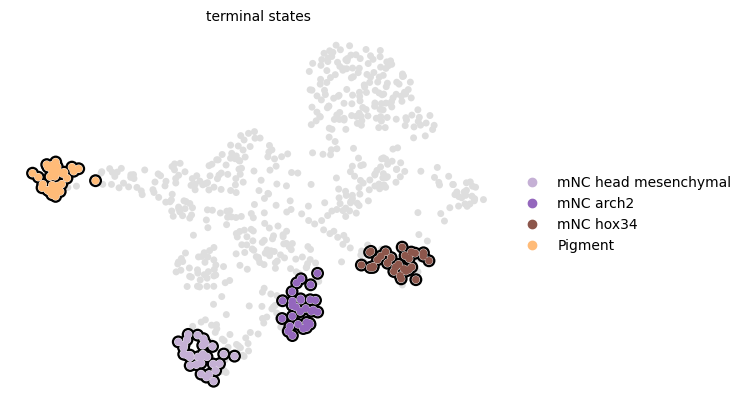

In [18]:
g.plot_macrostates(which="terminal", basis = "umap",legend_loc="right", s=100)

## Predict latent time

In [19]:
adata.obs["latent_time"] = min_max_scaling(adata.layers["fit_t"].mean(1))

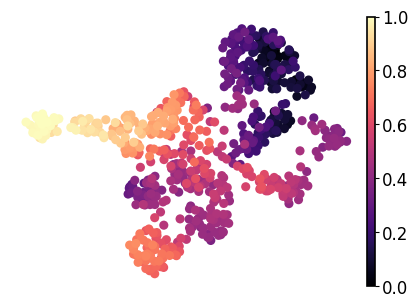

In [20]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize = (5,3.5))
    sc.pl.umap(
        adata = adata, 
        color="latent_time",
        title="",
        frameon = False,
        legend_fontsize = 14,
        cmap='magma',
        ax = ax
    )
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'latent_time.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )

In [21]:
df = pd.DataFrame({"stage":adata.obs["stage"].tolist(),
                   "latent_time":adata.obs["latent_time"].tolist()})

In [22]:
adata.obs["stage_num"] = 0
adata.obs["stage_num"][adata.obs["stage"].isin(["3ss"])] = 3
adata.obs["stage_num"][adata.obs["stage"].isin(["6-7ss"])] = 6.5
adata.obs["stage_num"][adata.obs["stage"].isin(["10ss"])] = 10
adata.obs["stage_num"][adata.obs["stage"].isin(["12-13ss"])] = 12.5
adata.obs["stage_num"][adata.obs["stage"].isin(["17-18ss"])] = 17.5
adata.obs["stage_num"][adata.obs["stage"].isin(["21-22ss"])] = 21.5

In [23]:
scipy.stats.spearmanr(adata.obs["stage_num"].tolist(),adata.obs["latent_time"].tolist())

SignificanceResult(statistic=0.7907994377969703, pvalue=2.580815480549031e-150)

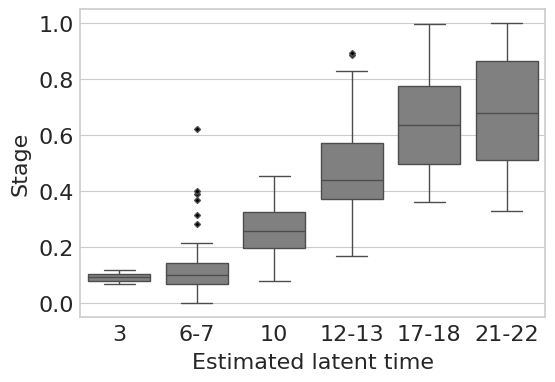

In [24]:
loc = [0, 1, 2, 3, 4,5]
label = ["3","6-7","10","12-13","17-18","21-22"]

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6,4))
    order = ["3ss","6-7ss","10ss","12-13ss","17-18ss","21-22ss"]
    flierprops = dict(marker='D', markerfacecolor='black', markersize=3, linestyle='none')
    sns.boxplot(data = df,x = "stage",y = "latent_time", order=order,color='grey',ax = ax, flierprops=flierprops)
    # Set labels and title
    plt.ylabel('Stage', fontsize=16)
    plt.xlabel('Estimated latent time', fontsize=16)


    plt.xticks(ticks=loc, labels=label)  # Replace ticks with new labels
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.show()
    
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / 'latent_time_boxplot.svg',
            format = 'svg',
            transparent = True,
            bbox_inches = 'tight'
        )
    plt.show()

In [25]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")